<a href="https://colab.research.google.com/github/georginobaltazar/Trabalhos-TP558/blob/main/Projeto%20Final/Projeto_Final_TP558.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este código é contem o Desenvolvimento do Projeto Final de TP558, Julho de 2024

Tema: Detecção de Anomalias em Imagens MRI Cerebrais
Utilizando Autoencoders Convolucionais

Nome: Georgino DA Silva Baltazar



## 1: Instalando Bibiliotecas

In [ ]:
!pip install numpy matplotlib keras tensorflow scikit-learn kaggle


## 2: Baixando e Preparar o Conjunto de Dados do kaggle

In [ ]:
import os
import zipfile

# Certifique-se de que você tem o arquivo kaggle.json no diretório ~/.kaggle/
os.environ['KAGGLE_CONFIG_DIR'] = "~/.kaggle"

# Baixar o conjunto de dados
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Extrair o conjunto de dados
with zipfile.ZipFile("brain-mri-images-for-brain-tumor-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_mri_images")


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 66% 10.0M/15.1M [00:00<00:00, 102MB/s]
100% 15.1M/15.1M [00:00<00:00, 129MB/s]


# 3: Carregar e Pré-processar os Dados

In [ ]:
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Função para carregar imagens
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=img_size, color_mode="grayscale")
        if img is not None:
            img = img_to_array(img)
            images.append(img)
    return np.array(images)

# Carregar e pré-processar o conjunto de dados
normal_images = load_images_from_folder('brain_mri_images/brain_tumor_dataset/no')
tumor_images = load_images_from_folder('brain_mri_images/brain_tumor_dataset/yes')

# Normalizar os valores dos pixels para o intervalo [0, 1]
normal_images = normal_images.astype('float32') / 255.
tumor_images = tumor_images.astype('float32') / 255.

# Dividir o conjunto de dados em treinamento e teste
x_train, x_test = train_test_split(normal_images, test_size=0.2, random_state=42)


# 4: Definir a Arquitetura do Modelo

In [ ]:
from keras.applications import VGG16
from keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, Dense, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import GlorotUniform

# Carregar a parte do codificador do VGG16 pré-treinado, excluindo as camadas totalmente conectadas
vgg16_encoder = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar as camadas do codificador
for layer in vgg16_encoder.layers:
    layer.trainable = False

# Definir o decodificador
encoded = Flatten()(vgg16_encoder.output)
encoded = Dense(512, activation='relu')(encoded)
x = Dense(256 * 16 * 16, activation='relu')(encoded)
x = Reshape((16, 16, 256))(x)
x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same', kernel_initializer=GlorotUniform())(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', kernel_initializer=GlorotUniform())(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', kernel_initializer=GlorotUniform())(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer=GlorotUniform())(x)

# Construir o modelo completo
autoencoder = Model(vgg16_encoder.input, decoded)

# Compilar o modelo
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

autoencoder.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

## 5: Treinar o Modelo

Epoch 1/100
3/3 [==============================] - 40s 13s/step - loss: 0.3273 - val_loss: 0.2940
Epoch 2/100
3/3 [==============================] - 31s 10s/step - loss: 0.2713 - val_loss: 0.2076
Epoch 3/100
3/3 [==============================] - 32s 10s/step - loss: 0.1989 - val_loss: 0.1654
Epoch 4/100
3/3 [==============================] - 32s 10s/step - loss: 0.1654 - val_loss: 0.1427
Epoch 5/100
3/3 [==============================] - 33s 11s/step - loss: 0.1389 - val_loss: 0.1323
Epoch 6/100
3/3 [==============================] - 32s 11s/step - loss: 0.1243 - val_loss: 0.1295
Epoch 7/100
3/3 [==============================] - 33s 10s/step - loss: 0.1198 - val_loss: 0.1241
Epoch 8/100
3/3 [==============================] - 32s 10s/step - loss: 0.1156 - val_loss: 0.1174
Epoch 9/100
3/3 [==============================] - 32s 11s/step - loss: 0.1127 - val_loss: 0.1137
Epoch 10/100
3/3 [==============================] - 31s 11s/step - loss: 0.1118 - val_loss: 0.1124
Epoch 11/100
3/3 [=

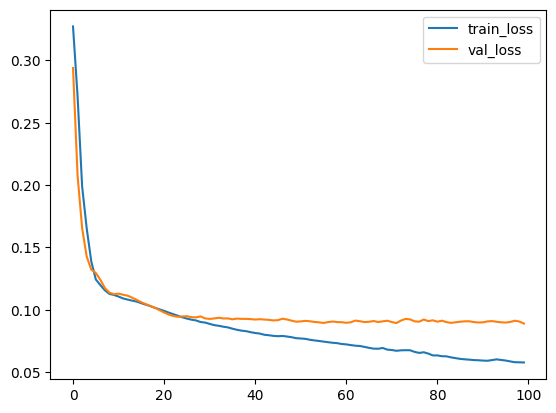

In [ ]:
# Expandir as imagens de entrada para três canais
x_train_expanded = np.repeat(x_train, 3, axis=-1)
x_test_expanded = np.repeat(x_test, 3, axis=-1)

history = autoencoder.fit(x_train_expanded, x_train,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_test_expanded, x_test))

# Plotar a perda de treinamento e validação ao longo das épocas
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


## 6: Avaliar e Visualizar os Resultados

1/1 [==============================] - 5s 5s/step


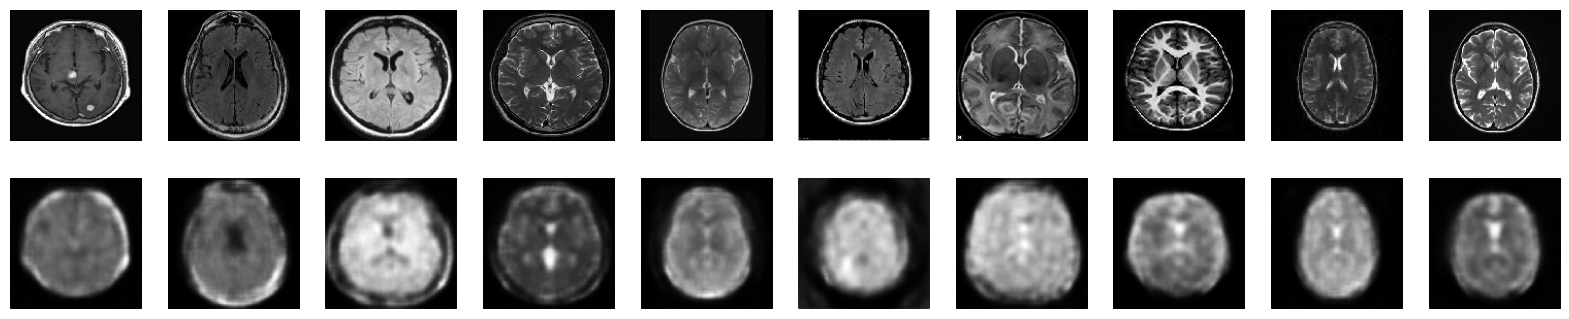

In [ ]:
# Avaliar o desempenho do modelo
decoded_imgs = autoencoder.predict(np.repeat(x_test, 3, axis=-1))

# Visualizar imagens originais e reconstruídas
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagens originais
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    ax.axis('off')

    # Imagens reconstruídas
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
    ax.axis('off')

plt.show()



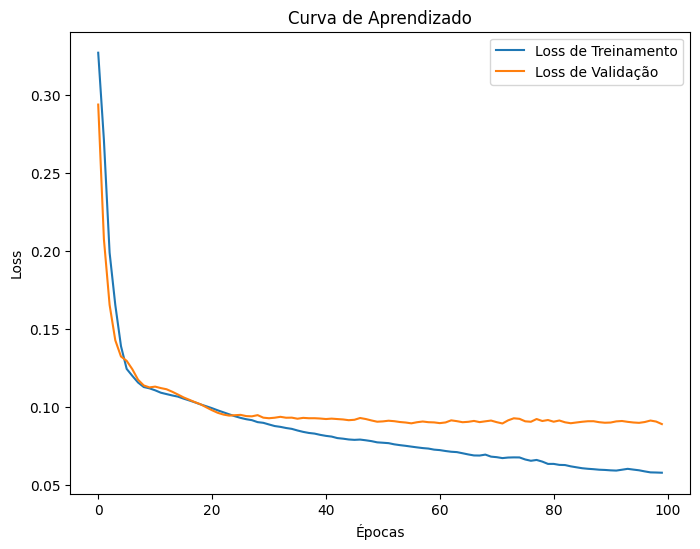

In [ ]:
# Plotar a curva de aprendizado
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

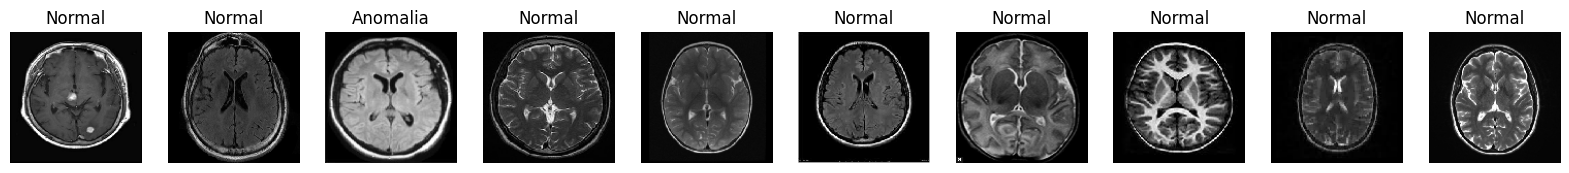

In [ ]:
import numpy as np

# Função para detectar anomalias com base no erro de reconstrução
def detectar_anomalias(x_original, x_reconstruida, limiar):
    erros = np.mean(np.abs(x_original - x_reconstruida), axis=(1, 2, 3))
    return erros > limiar

# Calcular o erro de reconstrução para o conjunto de testes
erros_reconstrucao = np.mean(np.abs(x_test - decoded_imgs), axis=(1, 2, 3))

# Definir um limiar de erro para considerar uma imagem como anômala
limiar_erro = np.percentile(erros_reconstrucao, 95)  # Ajuste conforme necessário

# Detectar anomalias no conjunto de teste
anomalias_detectadas = detectar_anomalias(x_test, decoded_imgs, limiar_erro)

# Visualizar as anomalias detectadas
plt.figure(figsize=(20, 4))
for i in range(10):
    # Imagens originais
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    ax.axis('off')
    ax.set_title("Anomalia" if anomalias_detectadas[i] else "Normal")
plt.show()



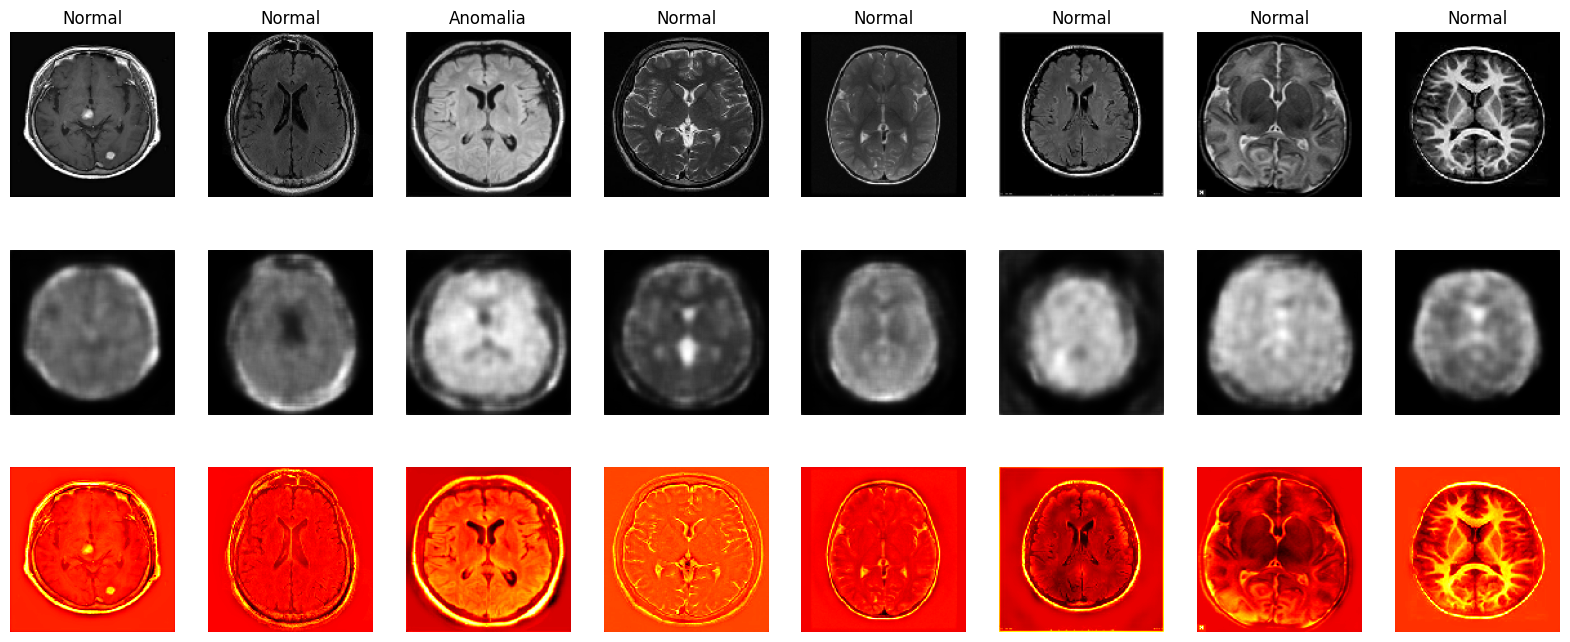

In [ ]:
import matplotlib.pyplot as plt

# Exibir as imagens originais, reconstruídas e se são anomalias
n = 8  # Número de imagens para exibir
plt.figure(figsize=(20, 8))
for i in range(n):
    # Imagens originais
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    plt.title("Anomalia" if anomalias_detectadas[i] else "Normal")
    ax.axis('off')

    # Imagens reconstruídas
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
    ax.axis('off')

    # Erros de reconstrução
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow((x_test[i] - decoded_imgs[i]).reshape(128, 128), cmap='hot')
    ax.axis('off')

plt.show()
